possible useful resources:


1.   https://www.ncbi.nlm.nih.gov/pmc/articles/PMC6201886/
2.   https://github.com/cialab/DeepFocus
3.   https://github.com/Utkarsh-Deshmukh/Spatially-Varying-Blur-Detection-python
4.   https://pyimagesearch.com/2015/09/07/blur-detection-with-opencv/
5.   https://github.com/WillBrennan/BlurDetection2






In [ ]:
# to save as tif in google drive
!pip install imagecodecs

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 36.1/36.1 MB 11.1 MB/s eta 0:00:00


In [ ]:
# ML model for cell segmentation
!pip install stardist

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 27.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 69.6/69.6 KB 6.9 MB/s eta 0:00:00


In [ ]:
from stardist.models import StarDist2D 
from stardist.data import test_image_nuclei_2d
from stardist.plot import render_label
from csbdeep.utils import normalize

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

from skimage import data, io, img_as_ubyte
from skimage.color import rgb2hed, hed2rgb
from skimage.exposure import rescale_intensity
from skimage.measure import regionprops_table
from skimage.segmentation import find_boundaries, mark_boundaries
import pandas as pd

from glob import glob

In [32]:
from google.colab.patches import cv2_imshow
import cv2

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount = True)

Mounted at /content/drive


In [ ]:
work_dir = '/content/drive/MyDrive/Lymphoma_PPFE_vs_Cryo/'          #you might need to change it in your case, look at your folder structure
img_dir = work_dir + 'images_1_CROPPED/'
auto_dir = work_dir + 'images_1_AUTO/alfa/'

In [ ]:
images = glob(img_dir + '*SELECTED*')                                #select only images containing SELECTED keyword in it

In [ ]:
# Separate the individual stains from the IHC image
def color_separate(ihc_rgb):

    #Convert the RGB image to HED using the prebuilt skimage method
    ihc_hed = rgb2hed(ihc_rgb)
    
    # Create an RGB image for each of the separated stains
    #Convert them to ubyte for easy saving to drive as an image
    null = np.zeros_like(ihc_hed[:, :, 0])
    ihc_h = img_as_ubyte(hed2rgb(np.stack((ihc_hed[:, :, 0], null, null), axis=-1)))
    ihc_e = img_as_ubyte(hed2rgb(np.stack((null, ihc_hed[:, :, 1], null), axis=-1)))
    ihc_d = img_as_ubyte(hed2rgb(np.stack((null, null, ihc_hed[:, :, 2]), axis=-1)))

    #Optional fun exercise of combining H and DAB stains into a single image with fluorescence look
    
    h = rescale_intensity(ihc_hed[:, :, 0], out_range=(0, 1),
                          in_range=(0, np.percentile(ihc_hed[:, :, 0], 99)))
    d = rescale_intensity(ihc_hed[:, :, 2], out_range=(0, 1),
                          in_range=(0, np.percentile(ihc_hed[:, :, 2], 99)))

# Cast the two channels into an RGB image, as the blue and green channels
#Convert to ubyte for easy saving as image to local drive
    zdh = img_as_ubyte(np.dstack((null, d, h))) #DAB in green and H in Blue

    return (ihc_h, ihc_e, ihc_d, zdh)

In [ ]:
# prints a list of available models 
StarDist2D.from_pretrained()
model = StarDist2D.from_pretrained('2D_versatile_he')
# model_2 = StarDist2D.from_pretrained('2D_versatile_fluo')

There are 4 registered models for 'StarDist2D':

Name                  Alias(es)
────                  ─────────
'2D_versatile_fluo'   'Versatile (fluorescent nuclei)'
'2D_versatile_he'     'Versatile (H&E nuclei)'
'2D_paper_dsb2018'    'DSB 2018 (from StarDist 2D paper)'
'2D_demo'             None
Found model '2D_versatile_he' for 'StarDist2D'.
5294730/5294730 [==============================] - 0s 0us/step
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


In [ ]:
# img = [i for i in images if '6_L-08 FFPE Exp 12 ms Gain 1 Satur 100_crop_1' in i][0]
# ihc_rgb=io.imread(img)
# H,E,D,HD = color_separate(ihc_rgb)
# H_labels, H_details = model.predict_instances(normalize(H))
# marked = mark_boundaries(ihc_rgb, H_labels, color=(1,0,0))
# plt.figure(figsize=(20,10))
# plt.subplot(1,3,1)
# plt.imshow(H)
# plt.axis("off")
# plt.title("H")

# plt.subplot(1,3,2)
# plt.imshow(render_label(H_labels, img=ihc_rgb))
# plt.axis("off")
# plt.title("segmentations")

# plt.subplot(1,3,3)
# plt.imshow(marked)
# plt.axis("off")
# plt.title("input+boundaries")

In [33]:
def variance_of_laplacian(image):
	# compute the Laplacian of the image and then return the focus
	# measure, which is simply the variance of the Laplacian
	return cv2.Laplacian(image, cv2.CV_64F).var()

In [59]:
H.shape[1]

862

In [62]:
H_analysis_results['bbox-2'].iloc[i]

506

In [63]:
stats = pd.DataFrame(columns = ['img', 'label', 'area', 'bbox', 'centroid'])
save_dir = auto_dir
for img in images:
    ihc_rgb=io.imread(img)
    if ihc_rgb.shape[-1] == 4:
        ihc_rgb = ihc_rgb[:, :, :3]
    H,E,D,HD = color_separate(ihc_rgb)
    # H = rgb2gray(H)
    H_labels, H_details = model.predict_instances(normalize(H))
    marked = mark_boundaries(ihc_rgb, H_labels, color=(1,0,0))
    fname = save_dir+img.split('/')[-1][:-4]+"_SEGMENTED.jpg"
    io.imsave(fname, marked)
    H_props = regionprops_table(H_labels, H, 
                          properties=['label',
                                      'area', 'bbox', 'centroid'])
    H_analysis_results = pd.DataFrame(H_props)
    H_analysis_results['img'] = img.split('/')[-1]
    ############ blurry
    small_images = []
    for i in range(H_analysis_results.shape[0]):
      miny = max(H_analysis_results['bbox-1'].iloc[i] - 10, 0)
      minx = max(H_analysis_results['bbox-0'].iloc[i] - 10, 0)
      maxy = H_analysis_results['bbox-3'].iloc[i] + 10
      maxx = H_analysis_results['bbox-2'].iloc[i] + 10
      crop = H[minx:maxx, miny:maxy, :]
      if len(list(list(crop)[0])) > 0:
        small_images.append(crop)
    fms = []
    for i in range(len(small_images)):
      # print(i)
      gray = cv2.cvtColor(small_images[i], cv2.COLOR_BGR2GRAY)
      fm = variance_of_laplacian(gray)
      fms.append(fm)
      if fm < 65:
        H_analysis_results.iloc[i]['label'] = 'None'
    ###########################################
    stats = pd.concat([stats, H_analysis_results])
stats.to_excel(save_dir+'measurements_from_stardist.xlsx', index=False)

1/1 [==============================] - 2s 2s/step


<ipython-input-63-00c8f4bd89bf> (35): 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


1/1 [==============================] - 1s 1s/step


<ipython-input-63-00c8f4bd89bf> (35): 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


1/1 [==============================] - 2s 2s/step


<ipython-input-63-00c8f4bd89bf> (35): 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


1/1 [==============================] - 2s 2s/step


<ipython-input-63-00c8f4bd89bf> (35): 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


1/1 [==============================] - 1s 921ms/step


<ipython-input-63-00c8f4bd89bf> (35): 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


1/1 [==============================] - 2s 2s/step


<ipython-input-63-00c8f4bd89bf> (35): 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


1/1 [==============================] - 1s 1s/step


<ipython-input-63-00c8f4bd89bf> (35): 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


1/1 [==============================] - 1s 968ms/step


<ipython-input-63-00c8f4bd89bf> (35): 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


1/1 [==============================] - 1s 967ms/step


<ipython-input-63-00c8f4bd89bf> (35): 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


1/1 [==============================] - 1s 640ms/step


1/1 [==============================] - 1s 1s/step


<ipython-input-63-00c8f4bd89bf> (35): 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


1/1 [==============================] - 2s 2s/step


<ipython-input-63-00c8f4bd89bf> (35): 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


1/1 [==============================] - 1s 1s/step


<ipython-input-63-00c8f4bd89bf> (35): 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


1/1 [==============================] - 1s 687ms/step


1/1 [==============================] - 1s 1s/step


<ipython-input-63-00c8f4bd89bf> (35): 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


1/1 [==============================] - 2s 2s/step


<ipython-input-63-00c8f4bd89bf> (35): 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


1/1 [==============================] - 2s 2s/step


<ipython-input-63-00c8f4bd89bf> (35): 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


1/1 [==============================] - 1s 1s/step


<ipython-input-63-00c8f4bd89bf> (35): 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


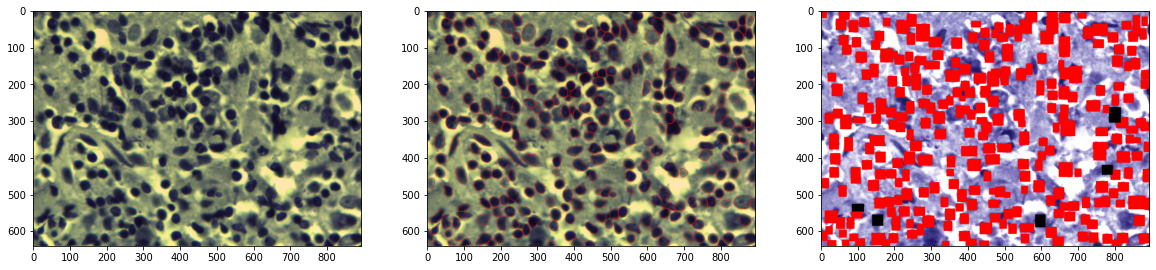

In [64]:
H,E,D,HD = color_separate(ihc_rgb)
for i in range(len(fms)):
  # color = fms[i]/max(fms)*255
  if fms[i] > 65:
    color = 255
  else:
    color = 0
  cv2.rectangle(H, (H_analysis_results['bbox-1'].iloc[i], H_analysis_results['bbox-0'].iloc[i]), \
          (H_analysis_results['bbox-3'].iloc[i], H_analysis_results['bbox-2'].iloc[i]), (color,0,0), -1)
  # break
plt.figure(figsize=(20,10))
plt.subplot(1,3,1)
plt.imshow(ihc_rgb)
plt.subplot(1,3,2)  
plt.imshow(marked)
plt.subplot(1,3,3)
plt.imshow(H)